# Inverse Kinematics Approximation Using Machine Learning

This notebook demonstrates an end‑to‑end pipeline for approximating the inverse kinematics (IK) of a 4‑DOF robotic arm using machine learning. We generate a large synthetic dataset in PyBullet, perform exploratory data analysis, preprocess the data (scaling and optional filtering), and train supervised models. Key evaluation metrics include joint‑angle mean absolute error (MAE), Cartesian end‑effector (EE) error, inference time, and qualitative visualizations.

All core functionality is encapsulated in **Methods.py**, which provides:

1. **Data generation** via Latin‑Hypercube sampling
2. **Data validation** to ensure quality and consistency
3. **Exploratory Data Analysis (EDA)** for joint angle distributions, workspace scatter plots, and cluster visualization
4. **Preprocessing**: normalization/scaling of input and output
5. **Supervised learning**: Clustered MLP regressors for pose→angle regression, with per-cluster training and best-match selection using forward kinematics
6. **Evaluation**: joint-angle MAE, end-effector error, timing comparisons, and PyBullet visualization of the robot and workspace

## 0. Version Check and Imports

Before proceeding, we verify that all required packages are at compatible versions, and then import our core utilities and libraries.

**Why Version Check?** <br>
Verifying your environment up‑front ensures you won’t hit import errors halfway through. Printing exact versions of Python and key libraries (NumPy, PyBullet, TensorFlow, etc.) also gives you a reproducible “software bill of materials,” which is invaluable if you need to debug or share your results later.

(Run in a terminal, *not* a Python cell) <br>
conda activate your_env_name <br>
conda install -c conda-forge pybullet numpy pandas tqdm scipy scikit-learn tensorflow h5py mlflow

In [1]:
# 0.0 Methods Functions
from Methods import (VersionChecker,
                     DatasetGenerator,
                     DataValidator,
                     IKDataEDA,
                     IKClusterer,
                     PerClusterRegressor,
                     clustered_ik_predict,
                     batch_clustered_ik_predict,
                     IKEvaluator
                     )

# 0.1 Standard Library Utilities
import numpy as np
import logging
import time
import joblib
import matplotlib.pyplot as plt

# 0.2 Scikit Learn Utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 0.3 PyBullet Utilities
import pybullet as p

#0.4 Scipy Utilities
from scipy.spatial.transform import Rotation as R

# 0.4 Version Checker
VersionChecker.check()

Python version: 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.26.4
pandas version: 2.0.3
pybullet version: n/a
scikit-learn version: 1.7.0


## 1. Dataset Generation — IK (Inverse Kinematics) Data

This section generates or loads a dataset of (joint angles, end-effector pose) pairs for a 4-DOF manipulator using PyBullet and Latin Hypercube Sampling.
If the dataset already exists, it will be loaded from disk.
The resulting DataFrame contains columns:
- `theta1, ..., theta6` (joint angles, radians)
- `x, y, z, qx, qy, qz, qw` (end-effector pose: position and orientation as quaternion)

**Notes:**
- If you want to regenerate the dataset (e.g., with more samples or different URDF), set `overwrite=True`.
- The URDF model must be present in the specified path (typically inside PyBullet's data folder).
- The number of samples (default 100,000) may take minutes to generate.

**Why Latin Hypercube Sampling (LHS)?** <br>
Latin Hypercube Sampling stratifies each joint’s range into equal intervals and samples one point per interval, giving more uniform multi-dimensional coverage than naive random draws, ensuring uniform coverage in 4‑D space with fewer samples than a full factorial grid. <br>
- *Curse of dimensionality:* Even a modest grid (e.g. 10 points per joint) gives 10⁶ combinations in 4 D—impossible to exhaustively sample. <br>
- *Uniform coverage:* LHS stratifies each joint’s domain into equal intervals and guarantees exactly one sample per interval per dimension, yielding far more even coverage than naive random sampling. <br>
- *Efficiency:* With 200 k total points, you capture the workspace more uniformly, avoiding large empty gaps or clumps.

In [2]:
# 1. User configuration
URDF_PATH = "simple_4dof.urdf"
OUTPUT_PATH = "ik_dataset.csv"
N_SAMPLES = 100_000
BATCH_SIZE = 1000
SEED = 42
N_DOF = 4   # <---- Set your robot DOF here!

# 2. Generate or load dataset
gen = DatasetGenerator(
    urdf_path=URDF_PATH,
    output_path=OUTPUT_PATH,
    n_samples=N_SAMPLES,
    batch_size=BATCH_SIZE,
    random_seed=SEED,
    n_dof=N_DOF
)

df = gen.run(overwrite=False)  # Set overwrite=True to regenerate from scratch

# 3. Quick preview
print(f"Dataset shape: {df.shape}")
display(df.head())

# Check column types and any missing values
print(df.dtypes)
print(f"Missing values:\n{df.isnull().sum()}")

Generating 99000-100000: 100%|██████████| 1000/1000 [00:00<00:00, 70130.65it/s]


Saved dataset to ik_dataset.csv (100000 rows)
Dataset shape: (100000, 11)


,theta1,theta2,theta3,theta4,x,y,z,qx,qy,qz,qw
0,-0.946066,-2.871700,-2.362570,-1.337005,0.104981,0.094660,0.244408,0.049005,0.393292,0.427977,0.812254
1,0.958884,1.571155,-0.094402,2.603901,0.213830,0.337521,0.299857,0.495026,0.505102,0.683614,-0.180257
2,2.414363,1.766707,2.069769,1.266080,0.040329,0.199197,0.279698,0.243779,0.627692,0.489214,0.554296
3,-2.165888,2.486073,0.614327,-2.836542,-0.219655,-0.118830,0.011896,-0.205063,0.884219,0.046198,-0.417098
4,1.066138,-1.727270,-0.039913,-1.696391,-0.197950,-0.341862,0.237690,0.744005,-0.155927,-0.215742,0.612862


theta1    float64
theta2    float64
theta3    float64
theta4    float64
x         float64
y         float64
z         float64
qx        float64
qy        float64
qz        float64
qw        float64
dtype: object
Missing values:
theta1    0
theta2    0
theta3    0
theta4    0
x         0
y         0
z         0
qx        0
qy        0
qz        0
qw        0
dtype: int64


## 2. Data Validation

Before diving into analysis, we verify the integrity of our raw CSV:
1. **No missing values**
2. **All entries finite**
3. **Compute MD5 checksum** for reproducibility

**Why Data Validation?** <br>
- *Catch bad values early:* NaNs or infinities can silently wreck downstream algorithms (scalers, DBSCAN, neural nets). <br>
- *Fail fast:* An explicit assert on missing or non‑finite values pinpoints issues in data generation, rather than during a later training run. <br>

In [3]:
# 1. Data validation for missing/infinite values
is_clean = DataValidator.check(df, name="IK Dataset")
if not is_clean:
    print("Warning: Dataset has missing or infinite values!")
else:
    print("IK Dataset is clean: no missing or infinite values found.")

IK Dataset: 0 missing, 0 infinite values.
IK Dataset is clean.
IK Dataset is clean: no missing or infinite values found.


## 3. Exploratory Data Analysis (EDA)

In this section, we visualize and analyze the generated IK dataset.

We will examine:
- End-effector workspace coverage
- Joint angle distributions
- Pairwise joint relationships (correlations, multimodality)
- End-effector orientation statistics

**Notes:**
- Workspace plot helps visualize spatial coverage and redundancy (multi-solution regions appear as "thick" or "folded" areas).
- Pairwise joint scatter matrices reveal possible clustering (e.g., elbow up/down) and joint dependencies.
- Orientation histograms reveal if certain end-effector attitudes are over/under-represented.

**Why EDA?** <br>
- *Understand distributions:* Joint‑angle histograms reveal whether some joints are under‑sampled or skewed. <br>
- Detect gaps or artifacts:* A 3D scatter of end‑effector positions shows the robot’s reachable workspace—ensuring you haven’t missed any regions. <br>
- *Inform preprocessing & modeling:* If you saw extreme outliers or clusters, you’d know to tweak your DBSCAN parameters or add targeted noise augmentation.

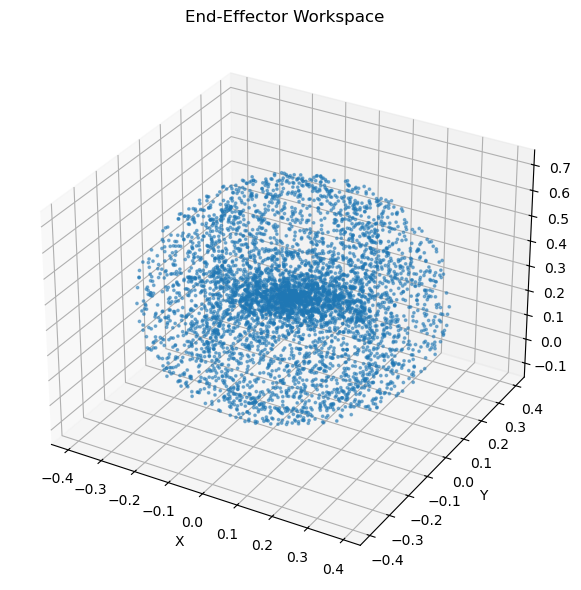

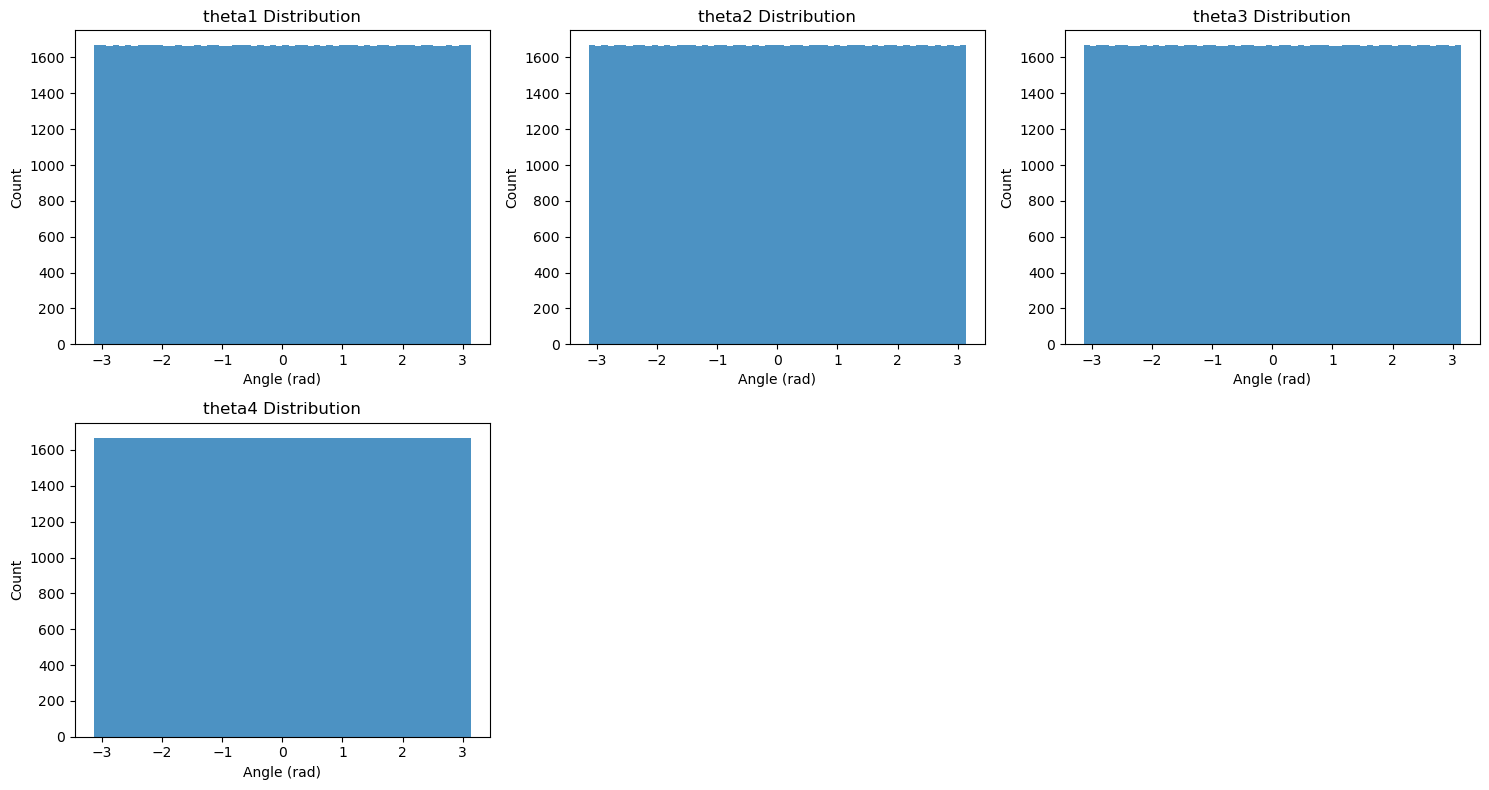

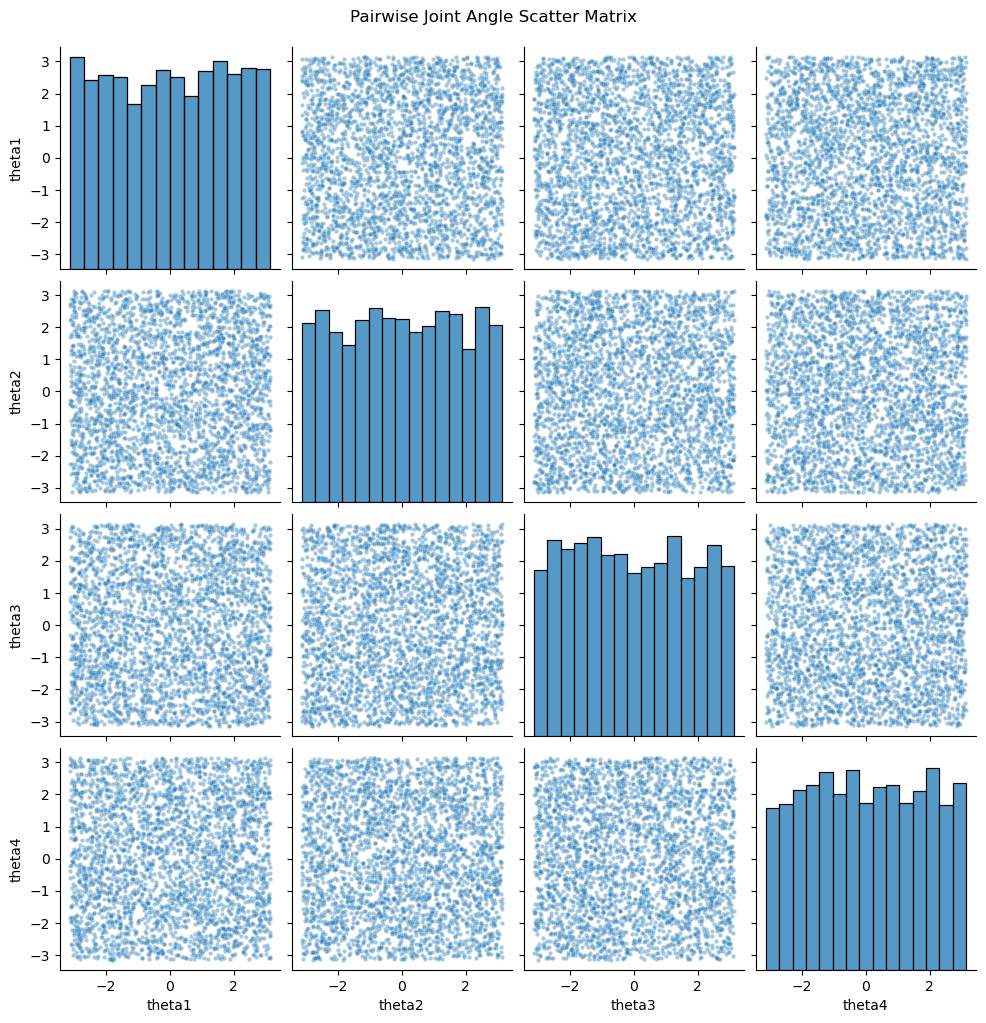

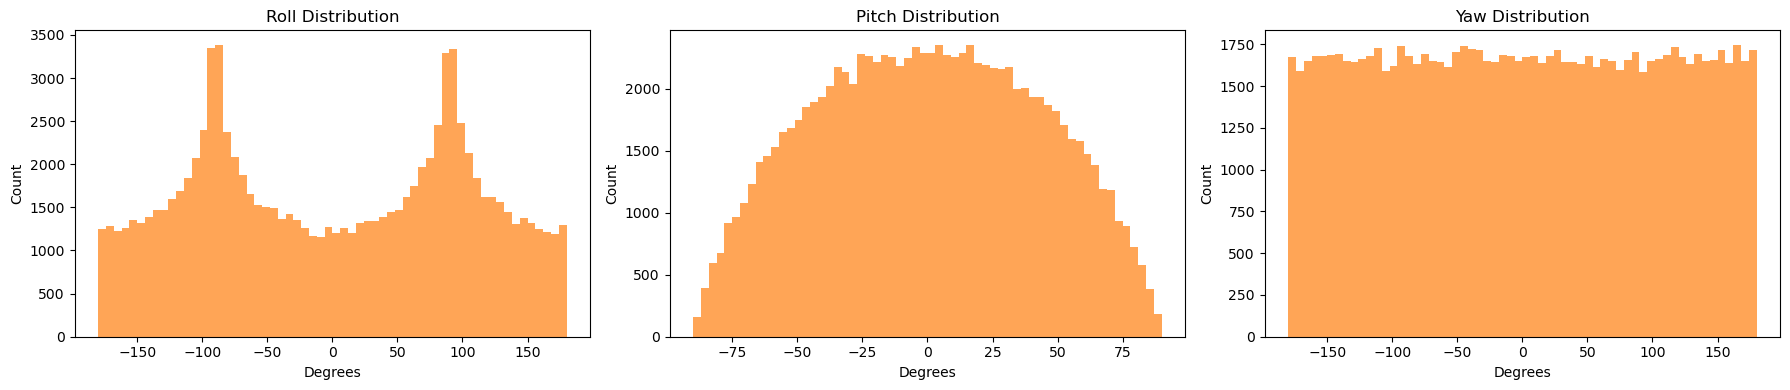

In [4]:
# 1. Initialize EDA class
eda = IKDataEDA(df)

# 2. 3D Workspace Plot (Position of End-Effector)
eda.plot_workspace(sample_size=5000)

# 3. Joint Angle Histograms
eda.plot_joint_histograms(bins=60)

# 4. Pairwise Scatter Matrix of Joint Angles (Reveal Multimodal Regions)
eda.plot_joint_pairplot(sample_size=3000)

# 5. Orientation Histograms (End-Effector Roll, Pitch, Yaw)
eda.plot_orientation_histograms(bins=60)

## 4. Clustering in Joint Space (Multi-Solution Partitioning)

Here, we apply KMeans clustering to the joint angle vectors (`theta1`...`theta6`) to identify families of IK solutions—such as "elbow up" and "elbow down".

We then visualize how these clusters correspond to distinct regions or overlaps in the end-effector workspace.

**Notes:**
- Distinct clusters indicate multiple IK solution families for the same end-effector pose (multi-solution regions).
- Cluster visualization in workspace reveals where redundancy or ambiguity in IK is present.
- You can increase `n_clusters` if your robot has more than two solution families.

C:\Users\jfons\miniconda3\envs\CS4641Project\lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\jfons\miniconda3\envs\CS4641Project\lib\site-packages\joblib\externals\loky\backend\context.py", line 255, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


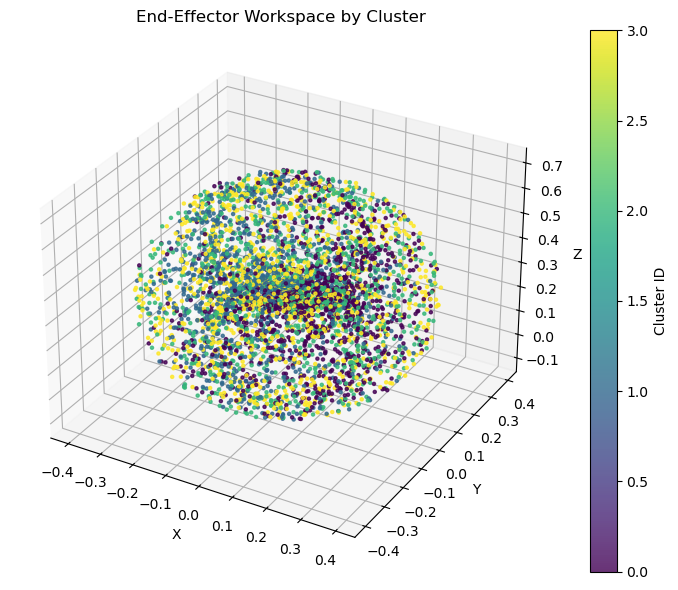

In [5]:
# 1. Extract joint angle data for clustering
theta_cols = [f"theta{i+1}" for i in range(N_DOF)]
joint_angles = df[theta_cols].values

# 2. Fit KMeans clustering
n_clusters = 4
clusterer = IKClusterer(n_clusters=n_clusters, random_state=42)
cluster_labels = clusterer.fit(joint_angles)
df["cluster"] = cluster_labels  # Store cluster assignments in DataFrame

# 3. Visualize clusters in workspace
eda.plot_workspace_by_cluster(df["cluster"], sample_size=5000)

## 5. Per-Cluster Regression and Multi-Solution IK Prediction

Now we train a separate supervised regressor for each joint-space cluster identified previously.
At inference, for a given pose, we use all cluster regressors and choose the solution whose FK is closest to the desired pose.
We persist our preprocessed splits (and any trained models) so they can be loaded later without re‑running the full pipeline.


**Notes:**
- Be sure your `fk_func` returns the correct pose format for your robot (at least [x, y, z]).
- This method ensures that for ambiguous poses (multiple joint solutions), the correct “family” can be chosen via FastFK
- Next: Evaluate accuracy in joint space and workspace.

In [6]:
class FastFK:
    """
    Utility class for forward kinematics (FK) evaluation using PyBullet.
    Returns the end-effector pose for a given joint configuration.
    """
    def __init__(self, urdf_path="simple_4dof.urdf", n_dof=N_DOF):
        """
        Initializes the PyBullet simulation, loads the robot from URDF,
        and identifies the revolute joints to use for FK.

        Args:
            urdf_path (str): Path to your URDF file.
            n_dof (int): Number of revolute joints (must match robot DOF).
        """
        import pybullet as p
        import pybullet_data
        self.urdf_path = urdf_path
        self.n_dof = n_dof
        self.client = p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        self.robot = p.loadURDF(urdf_path, useFixedBase=True)
        self.joint_ids = [
            i for i in range(p.getNumJoints(self.robot))
            if p.getJointInfo(self.robot, i)[2] == p.JOINT_REVOLUTE
        ][:self.n_dof]
        assert len(self.joint_ids) == self.n_dof, f"Robot model must have {self.n_dof} revolute joints."

    def __call__(self, joint_angles):
        """
        Computes the end-effector pose for a given set of joint angles.

        Args:
            joint_angles (array-like): Joint angles in radians.

        Returns:
            np.ndarray: [x, y, z, qx, qy, qz, qw] pose of the end effector.
        """
        import pybullet as p
        for jid, ang in zip(self.joint_ids, joint_angles):
            p.resetJointState(self.robot, jid, ang)
        link_state = p.getLinkState(self.robot, self.joint_ids[-1], computeForwardKinematics=True)
        pos, orn = link_state[4], link_state[5]
        return np.array([*pos, *orn])

    def disconnect(self):
        """
        Disconnects from the PyBullet simulation.
        """
        import pybullet as p
        p.disconnect(self.client)

In [7]:
logging.basicConfig(
    level=logging.DEBUG,  # Change to DEBUG for more detail
    format='%(asctime)s %(levelname)s: %(message)s',
    handlers=[logging.StreamHandler()]
)

logging.info("1. Data Preprocessing (normalize and split)")
start = time.time()

quats = df[["qx","qy","qz","qw"]].to_numpy()
yaws = R.from_quat(quats).as_euler('zyx', degrees=False)[:,0]
df["yaw"] = yaws

pose_cols = ["x", "y", "z", "yaw"]
theta_cols = [f"theta{i+1}" for i in range(N_DOF)]

X = df[pose_cols].values
Y = df[theta_cols].values
clusters = df["cluster"].values

scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_norm = scaler_X.fit_transform(X)
Y_norm = scaler_Y.fit_transform(Y)

X_train, X_test, Y_train, Y_test, clusters_train, clusters_test, X_orig_train, X_test_orig = train_test_split(
    X_norm, Y_norm, clusters, X, test_size=0.15, random_state=42, stratify=clusters
)

logging.info(f"   ...done in {time.time() - start:.2f} seconds.")

# 2. Train Per-Cluster Regressor (MLP by default)
logging.info("2. Training Per-Cluster Regressor...")
start = time.time()

regressor = PerClusterRegressor()
regressor.fit(X_train, Y_train, clusters_train)

logging.info(f"   ...regressor training complete in {time.time() - start:.2f} seconds.")

# 3. Predict on Test Set using FK-based Best-Match
logging.info("3. Predicting on Test Set using FK-based Best-Match...")
start = time.time()

fast_fk = FastFK(urdf_path="simple_4dof.urdf", n_dof=N_DOF)
def fk_func_unnorm(y_pred_norm):
    y_pred = scaler_Y.inverse_transform(y_pred_norm.reshape(1, -1))[0]
    return fast_fk(y_pred)

Y_pred_norm = regressor.predict(X_test, fk_func=fk_func_unnorm, poses=X_test_orig)

logging.info(f"   ...prediction complete in {time.time() - start:.2f} seconds.")

# Unnormalize predictions for further evaluation
logging.info("4. Unnormalizing predictions...")
Y_pred = scaler_Y.inverse_transform(Y_pred_norm)
Y_true = scaler_Y.inverse_transform(Y_test)
logging.info("   ...unnormalization complete.")

fast_fk.disconnect()
logging.info("Finished! FK client disconnected.")

# After training and prediction:
logging.info("5. Saving results...")

# Save predictions and ground truth (for future visualization)
np.savez("ik_results_for_viz.npz",
         Y_true=Y_true,
         Y_pred=Y_pred,
         X_test_orig=X_test_orig,
         clusters_test=clusters_test)

# Save the regressor (full model, optionally)
joblib.dump(regressor, "per_cluster_regressor.joblib")

# Save loss curves for each cluster in a separate npz
loss_curves = {}
for c, model in regressor.cluster_models.items():
    if hasattr(model, "loss_curve_"):
        loss_curves[f"cluster_{c}"] = np.array(model.loss_curve_)
np.savez("ik_loss_curves.npz", **loss_curves)

logging.info("Saved: ik_results_for_viz.npz, per_cluster_regressor.joblib, ik_loss_curves.npz")

2025-07-22 20:46:17,592 INFO: 1. Data Preprocessing (normalize and split)
2025-07-22 20:46:17,673 INFO:    ...done in 0.08 seconds.
2025-07-22 20:46:17,673 INFO: 2. Training Per-Cluster Regressor...
C:\Users\jfons\miniconda3\envs\CS4641Project\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
2025-07-22 20:59:08,626 INFO:    ...regressor training complete in 770.95 seconds.
2025-07-22 20:59:08,626 INFO: 3. Predicting on Test Set using FK-based Best-Match...
2025-07-22 20:59:11,970 INFO:    ...prediction complete in 3.34 seconds.
2025-07-22 20:59:11,970 INFO: 4. Unnormalizing predictions...
2025-07-22 20:59:11,970 INFO:    ...unnormalization complete.
2025-07-22 20:59:11,981 INFO: Finished! FK client disconnected.
2025-07-22 20:59:11,981 INFO: 5. Saving results...
2025-07-22 20:59:12,039 INFO: Saved: ik_results_for_viz.npz, per_clus

# 6. Clustered IK Prediction (Manual, Best-Match Style)

Here, we manually use the list of per-cluster regressors to predict joint angles for new poses,
choosing the best solution (per sample) as the one whose FK is closest to the input pose.

**This approach is equivalent to what is built into PerClusterRegressor.predict(), but exposes the logic explicitly and can be used for research/debugging.**
Each test pose is evaluated by all regressors, and the result whose FK output is closest to the input pose is chosen as the prediction.

In [8]:
# Prepare list of trained regressors (from your PerClusterRegressor instance)
regressors = [regressor.cluster_models[c] for c in sorted(regressor.cluster_models.keys())]

# We use the same normalization/scaling as before
# X_test: normalized poses, X_test_orig: original (unnormalized) poses
# Define the FK function for unnormalized joint angles as before
fast_fk = FastFK(urdf_path="simple_4dof.urdf", n_dof=N_DOF)
def fk_func_unnorm(y_pred_norm):
    y_pred = scaler_Y.inverse_transform(y_pred_norm.reshape(1, -1))[0]
    return fast_fk(y_pred)  # Should return [x, y, z, ...]

# Predict for all test samples (batch version)
Y_pred = batch_clustered_ik_predict(
    regressors=regressors,
    poses=X_test,
    fk_func=fk_func_unnorm,
    input_poses=X_test_orig
)

# If your joint angles were normalized for training, unnormalize here (if notebook is unedited, you must unnormalize)
Y_pred = scaler_Y.inverse_transform(Y_pred)
Y_true = scaler_Y.inverse_transform(Y_test)

## 7. Evaluation of IK Regression Performance

We evaluate the clustered (multi-model) approach using:
- Joint-space Mean Absolute Error (MAE)
- End-effector workspace (task-space) error via FK

**Interpretation:**
- Joint MAE would be important if constraints were imposed to the robot (should keep a close eye on it if using a new custom robot with constraints)
- EE error is the main metric for comparison, being the averaged Euclidean distance of prediction and ground truth. In this case, ground truth refers to the desired coordinate, and the prediction is found by converting the predicted angles to the resulting coordinate.
- For in-depth analysis, you may also plot histograms or boxplots of the errors. Some suggested Visualizations are also below.

In [9]:
# 1. Prepare: FK and Evaluator
fast_fk = FastFK(urdf_path="simple_4dof.urdf", n_dof=N_DOF)
evaluator = IKEvaluator(fk_func=fast_fk)

# 2. Clustered ML Prediction & Timing
start = time.time()
Y_pred_ml = batch_clustered_ik_predict(
    regressors=regressors,
    poses=X_test,
    fk_func=fk_func_unnorm,
    input_poses=X_test_orig
)
ml_time = time.time() - start

Y_pred_ml = scaler_Y.inverse_transform(Y_pred_ml)
Y_true = scaler_Y.inverse_transform(Y_test)

mae_ml = evaluator.joint_mae(Y_true, Y_pred_ml)
ee_ml, _ = evaluator.ee_position_error(Y_true, Y_pred_ml)

# 3. PyBullet IK Prediction & Timing
def pybullet_ik_solver(target_pose):
    # target_pose: [x, y, z, yaw]
    # Convert yaw to quaternion for PyBullet IK
    x, y, z, yaw = target_pose
    orn = R.from_euler('zyx', [yaw, 0, 0], degrees=False).as_quat()
    fast_fk = FastFK(urdf_path="simple_4dof.urdf", n_dof=N_DOF)
    client = fast_fk.client
    robot = fast_fk.robot
    # Uses only position+orientation IK
    joint_angles = p.calculateInverseKinematics(
        robot,
        fast_fk.joint_ids[-1],
        [x, y, z],
        orn
    )[:N_DOF]
    fast_fk.disconnect()
    return np.array(joint_angles)

start = time.time()
n_pb = 1000
Y_pred_pb = np.vstack([pybullet_ik_solver(pose) for pose in X_test_orig[:n_pb]])
ik_time = time.time() - start

y_true_pb = Y_true[:n_pb]
mae_pb = evaluator.joint_mae(y_true_pb, Y_pred_pb)
ee_pb, _ = evaluator.ee_position_error(y_true_pb, Y_pred_pb)

# 4. Summary Table
print("=== Inverse Kinematics Comparison ===")
print(f"Method         | Joint MAE | EE Error [m] | Total Time (s) | Time per sample (ms)")
print(f"ML (Clustered) |  {mae_ml:.5f}   |   {ee_ml:.5f}   |   {ml_time:.2f}        |   {1000*ml_time/len(X_test):.2f}")
print(f"PyBullet IK    |  {mae_pb:.5f}   |   {ee_pb:.5f}   |   {ik_time:.2f}        |   {1000*ik_time/n_pb:.2f}")

=== Inverse Kinematics Comparison ===
Method         | Joint MAE | EE Error [m] | Total Time (s) | Time per sample (ms)
ML (Clustered) |  1.76499   |   0.05097   |   9.84        |   0.66
PyBullet IK    |  1.63432   |   0.44443   |   14.12        |   14.12


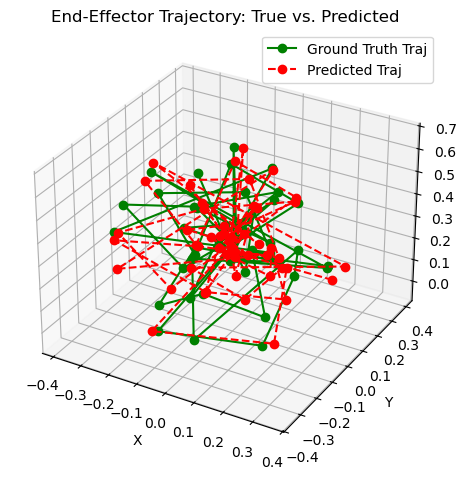

In [10]:
# End-Effector trajectory for both ground-truths and predicted points
traj_idx = np.arange(50)
true_xyz = np.array([fast_fk(j)[:3] for j in Y_true[traj_idx]])
pred_xyz = np.array([fast_fk(j)[:3] for j in Y_pred[traj_idx]])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(true_xyz[:,0], true_xyz[:,1], true_xyz[:,2], 'go-', label='Ground Truth Traj')
ax.plot(pred_xyz[:,0], pred_xyz[:,1], pred_xyz[:,2], 'ro--', label='Predicted Traj')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('End-Effector Trajectory: True vs. Predicted')
plt.tight_layout()
plt.show()

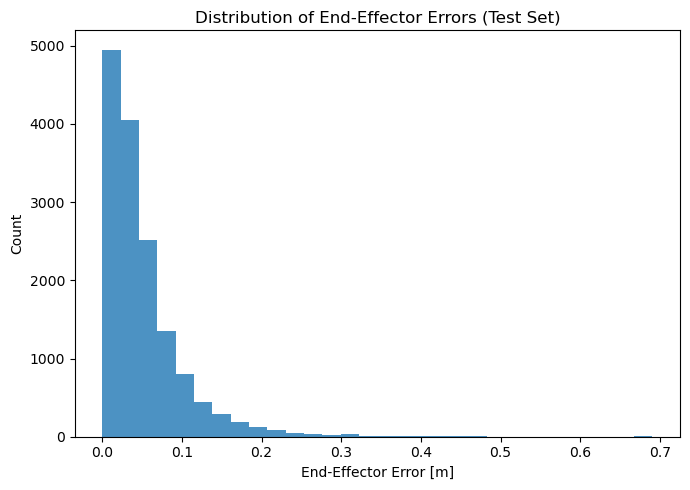

In [11]:
# Compute EE errors for all test samples
ee_errors = np.linalg.norm(
    np.array([fast_fk(j)[:3] for j in Y_true]) -
    np.array([fast_fk(j)[:3] for j in Y_pred]), axis=1
)

plt.figure(figsize=(7,5))
plt.hist(ee_errors, bins=30, alpha=0.8, color='C0')
plt.xlabel("End-Effector Error [m]")
plt.ylabel("Count")
plt.title("Distribution of End-Effector Errors (Test Set)")
plt.tight_layout()
plt.show()

2025-07-22 21:00:06,411 DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x00000233193BCCD0>


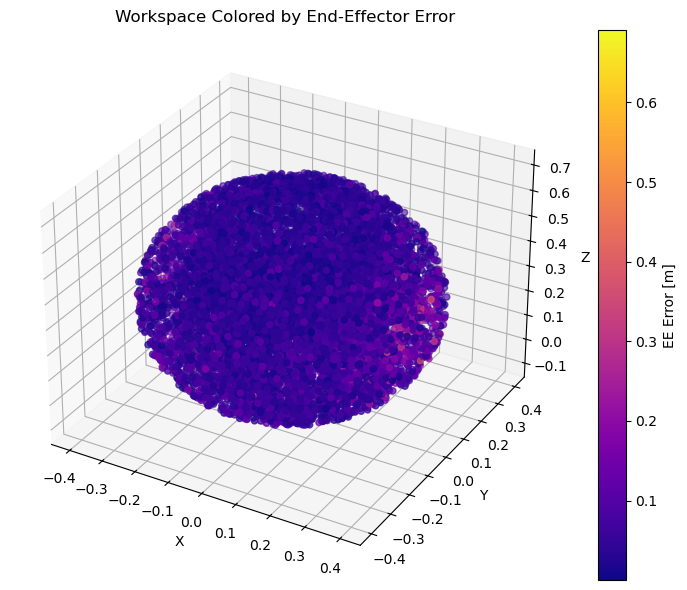

In [12]:
# Workspace Colored by End-Effector Error
xyz = np.array([fast_fk(j)[:3] for j in Y_true])
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c=ee_errors, cmap='plasma', s=20)
fig.colorbar(p, ax=ax, label="EE Error [m]")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Workspace Colored by End-Effector Error")
plt.tight_layout()
plt.show()

Worst 10 Test Samples (by EE Error):
  Index 8703: Error=0.6905 m, Target Pose=[ 0.01477872  0.0256372  -0.09884047 -0.05661024]
    True Angles: [-1.85098717 -3.06969722 -0.03557103  1.23431878]
    Pred Angles: [ 2.15092141  5.19437719 -0.17193731 -0.84601281]
---


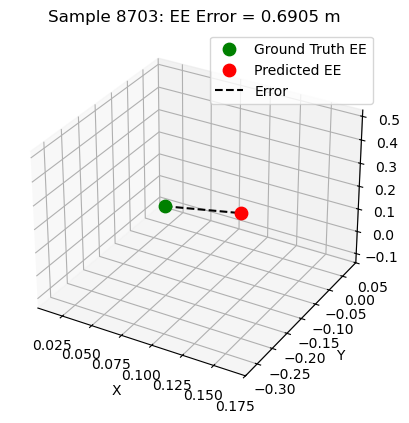

  Index 10976: Error=0.6875 m, Target Pose=[-0.10195279 -0.0816223  -0.06577035 -0.684862  ]
    True Angles: [-1.67503788  2.89572612  0.48310567  0.77031249]
    Pred Angles: [-1.16261578  0.67189545  0.52315128  1.11787968]
---


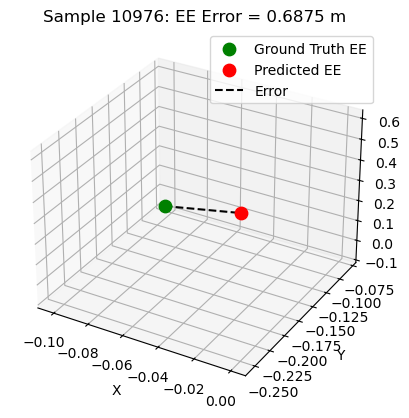

  Index 5181: Error=0.6711 m, Target Pose=[-0.0463922  -0.10944802 -0.06174608 -1.21898079]
    True Angles: [-0.59587145  3.07801891  0.62255426  1.39023617]
    Pred Angles: [-0.37572685  0.45536641  0.89346699  1.74772422]
---


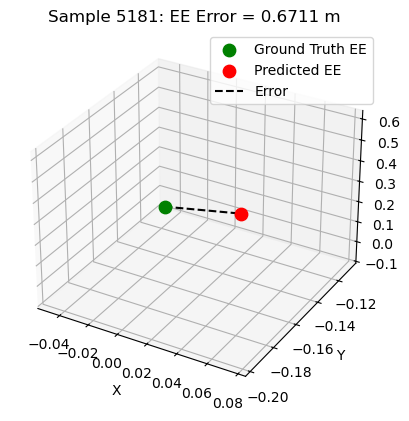

  Index 299: Error=0.6288 m, Target Pose=[-0.08968957 -0.08297324 -0.06943791 -0.78686627]
    True Angles: [-0.08325579 -2.92193969  0.46757394  2.37902204]
    Pred Angles: [-0.90209276  1.11816433  0.47993157  1.13093578]
---


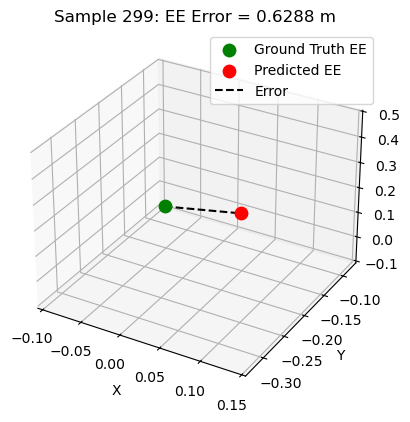

  Index 9473: Error=0.6085 m, Target Pose=[-0.09438093 -0.10255364 -0.04985022 -0.78155774]
    True Angles: [-1.16950035  2.97858156  0.6876302   1.26308883]
    Pred Angles: [-0.75480129  0.97565095  0.79704237  1.29361144]
---


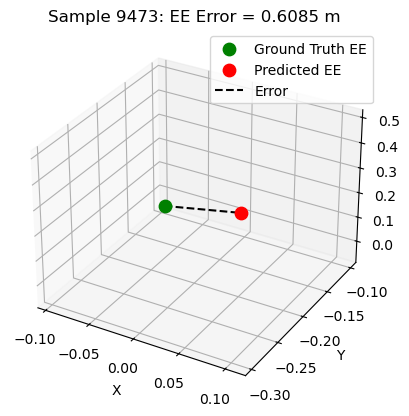

  Index 4479: Error=0.5931 m, Target Pose=[-0.10693723 -0.08508532 -0.07095118 -0.87577011]
    True Angles: [-2.01267858  2.82228689  0.30615905  0.23596717]
    Pred Angles: [-1.12483058  1.27448322  0.3797445   1.00717542]
---


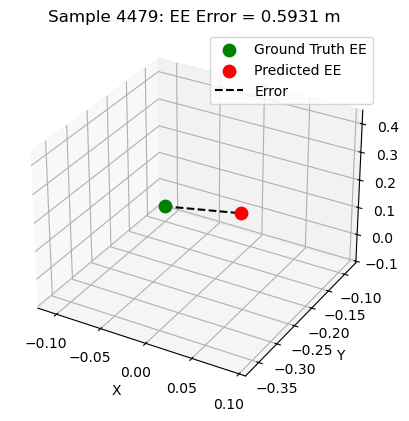

  Index 7472: Error=0.5893 m, Target Pose=[-0.08835632 -0.07955262 -0.07491342 -1.10854612]
    True Angles: [ 1.37944964 -2.89366381 -0.36620168 -2.88141082]
    Pred Angles: [ 0.87400519 -1.16120727 -0.05092595 -2.71138734]
---


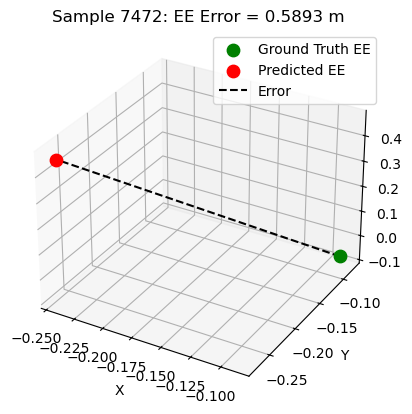

  Index 7844: Error=0.5451 m, Target Pose=[ 0.07720807  0.02958881 -0.08260711 -0.53679622]
    True Angles: [-0.97716052  3.09285539 -0.4145197   1.67571188]
    Pred Angles: [-0.77358262  1.30960871 -0.9456857   1.67202822]
---


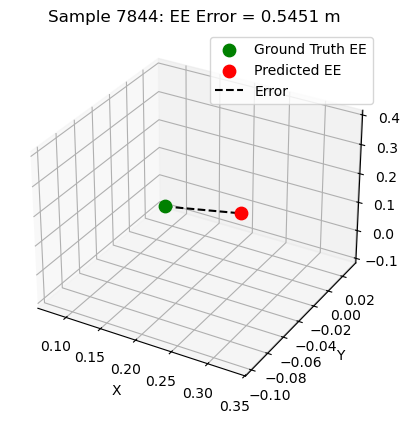

  Index 5022: Error=0.5383 m, Target Pose=[-0.10970511 -0.10644495 -0.03720618 -0.58455668]
    True Angles: [-1.21118196  2.96254579  0.77642692  1.43907896]
    Pred Angles: [ 1.82141172 -1.39257029  0.09293189 -1.67482655]
---


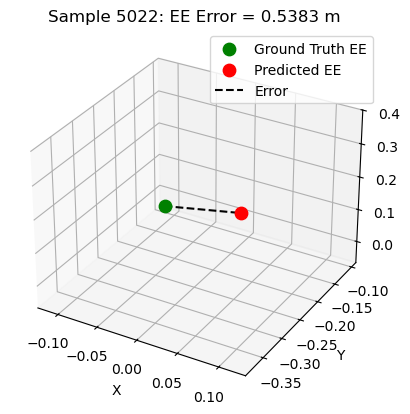

  Index 1262: Error=0.5136 m, Target Pose=[ 0.12857769  0.01307584 -0.0545589  -0.02915862]
    True Angles: [-1.21588902  3.05040794 -0.67582649  1.99417929]
    Pred Angles: [-1.00452969  1.44198636 -0.4695533  -1.53602253]
---


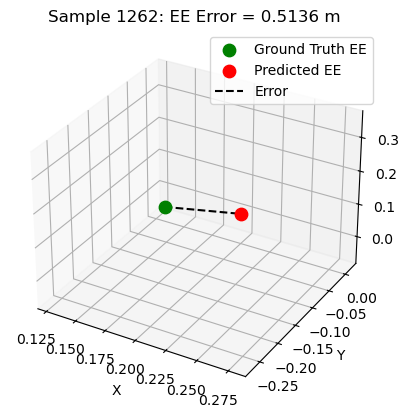

In [13]:
# Plot the 10 worst predictions by EE Error
worst_n = 10
worst_idxs = np.argsort(-ee_errors)[:worst_n]
print(f"Worst {worst_n} Test Samples (by EE Error):")
for idx in worst_idxs:
    print(f"  Index {idx}: Error={ee_errors[idx]:.4f} m, Target Pose={X_test_orig[idx]}")
    print(f"    True Angles: {Y_true[idx]}")
    print(f"    Pred Angles: {Y_pred[idx]}")
    print("---")
    # Optional: visualize them
    t_xyz = fast_fk(Y_true[idx])[:3]
    p_xyz = fast_fk(Y_pred[idx])[:3]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*t_xyz, c='g', s=80, label='Ground Truth EE')
    ax.scatter(*p_xyz, c='r', s=80, label='Predicted EE')
    ax.plot([t_xyz[0], p_xyz[0]], [t_xyz[1], p_xyz[1]], [t_xyz[2], p_xyz[2]], 'k--', label='Error')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.legend()
    plt.title(f"Sample {idx}: EE Error = {ee_errors[idx]:.4f} m")
    plt.show()